# Tarea practica II - Modelo exponencial de Covid-19
<br>**Norman Daniel Vicente-17001455**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from google.colab import drive 
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [3]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Tablero de Covid-19 mundial

In [4]:
covid19_data = pd.read_csv('covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
29035,NaN,Western Sahara,24.215500,-12.885800,2020-05-10,6,0,5
29036,NaN,Sao Tome and Principe,0.186360,6.613081,2020-05-10,208,5,4
29037,NaN,Yemen,15.552727,48.516388,2020-05-10,51,8,1
29038,NaN,Comoros,-11.645500,43.333300,2020-05-10,11,1,0
29039,NaN,Tajikistan,38.861034,71.276093,2020-05-10,612,20,0


## Filtramos para Guatemala

In [5]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()

## Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1

In [6]:
df = GT_confirmed.groupby("Date").sum()
df.tail()

,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,
2020-05-06,15.7835,-90.2308,798,21,86
2020-05-07,15.7835,-90.2308,832,23,90
2020-05-08,15.7835,-90.2308,900,24,101
2020-05-09,15.7835,-90.2308,967,24,104
2020-05-10,15.7835,-90.2308,1052,26,110


In [7]:
index = df.index
index.to_numpy()
dic={}
for i in range(0, len(index)):
  dic[str(index[i])] = i

### Transformacion de la variable `Date` a tipo numerica

In [8]:
GT_confirmed['Date'] = GT_confirmed['Date'].apply(lambda date: dic.get(str(date)) if str(date) in dic else '-1')

In [9]:
GT_confirmed.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
13851,NaN,Guatemala,15.7835,-90.2308,0,1,0,0
14115,NaN,Guatemala,15.7835,-90.2308,1,1,0,0
14379,NaN,Guatemala,15.7835,-90.2308,2,2,1,0
14643,NaN,Guatemala,15.7835,-90.2308,3,6,1,0
14907,NaN,Guatemala,15.7835,-90.2308,4,6,1,0


## Suma de casos por dia

In [ ]:
q = GT_confirmed.groupby("Date").sum()
q.head()

,Lat,Long,Confirmed,Deaths,Recovered,n,ln(confirmed)
Date,,,,,,,
0,15.7835,-90.2308,1,0,0,0,0.000000
1,15.7835,-90.2308,1,0,0,1,0.000000
2,15.7835,-90.2308,2,1,0,2,0.693147
3,15.7835,-90.2308,6,1,0,3,1.791759
4,15.7835,-90.2308,6,1,0,4,1.791759


## Casos confirmados de Covid-19 para Guatemala

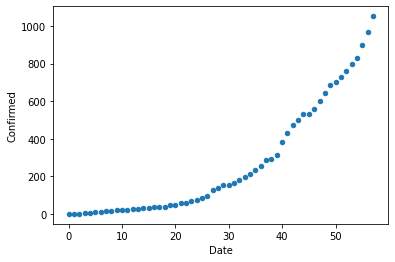

In [ ]:
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

## Transformacion de Log

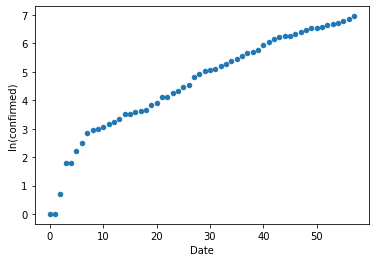

In [ ]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

## Variable independiente y dependiente

In [ ]:
x= GT_confirmed['Date'].astype(int)
y= GT_confirmed['ln(confirmed)']


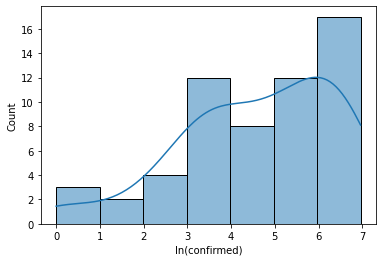

In [ ]:
sns.histplot(y,kde=True)

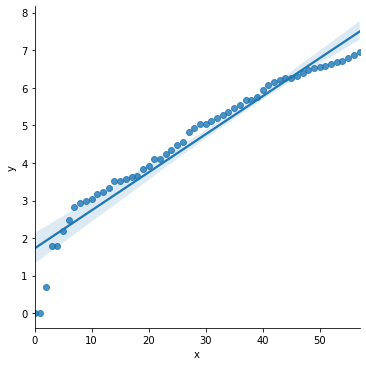

In [ ]:
params = pd.DataFrame.from_dict({"y": y,"x": x})
sns.lmplot(x='x', y='y', data= params, order=1)

## Planteamiento del problema

<img src="https://camo.githubusercontent.com/889524b4f326d198c78d5aa30c663b4f98a5df2c/68747470733a2f2f6769746875622e636f6d2f6e6f726d616e617370782f446174612d536369656e63652f626c6f622f6d61737465722f7265736f75726365732f6c6e2e706e673f7261773d74727565"/>

In [ ]:
tf.reset_default_graph()
n = len(x)
tensor_x = tf.placeholder(tf.float32,[n],"tensor_x")
tensor_y = tf.placeholder(tf.float32,[n],"tensor_y")
learning_rate = tf.placeholder("float") 

m = tf.get_variable("pendiente",dtype=tf.float32, shape=[],
                    initializer=tf.zeros_initializer())
b = tf.get_variable("intercepto",dtype=tf.float32, shape=[],
                    initializer=tf.zeros_initializer())
# Hypothesis
y_pred = tf.add(tf.multiply(m, x), b)
  
# Mean Squared Error Cost Function
cost = tf.reduce_sum(tf.pow(y_pred-tensor_y, 2)) / (2 * n)

#Cost to Tensorboard  
cost_summary = tf.summary.scalar("cost", cost)

# Gradient Descent Optimizer
optimizer = tf.gradients(cost ,[m,b])
  
actualizacion_m = tf.assign(m, m - learning_rate*optimizer[0] )
actualizacion_b = tf.assign(b, b - learning_rate*optimizer[1] )
actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

# Global Variables Initializer
init = tf.global_variables_initializer()

In [ ]:
def linear_model (EPOCHS, lr): 
  plt.scatter(x,y)
  with tf.train.MonitoredSession() as session:
    session.run(init)
    now = datetime.now()
    feed_dict = {tensor_x:x, tensor_y:y, learning_rate:lr}
    writer = tf.summary.FileWriter("f/"+str(now)+" lr="+str(lr), session.graph)
    for epoch in range(EPOCHS):
      session.run(optimizer,feed_dict=feed_dict)
      session.run(actualizacion_parametros,feed_dict=feed_dict)
      predict_value, cs = session.run([y_pred, cost_summary],feed_dict=feed_dict)
      writer.add_summary(cs, epoch+1)
      plt.plot(x,predict_value,label=str(epoch))
      pendiente, intercepto = session.run([m,b],feed_dict=feed_dict)
      plt.title("Pendiente: m={}  b={}".format(pendiente, intercepto))

  return intercepto, pendiente

### Experimentos

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


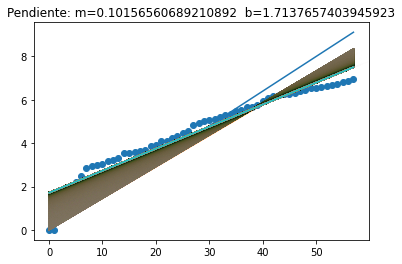

In [204]:
beta_0, beta_1 = linear_model(20000, 0.001)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


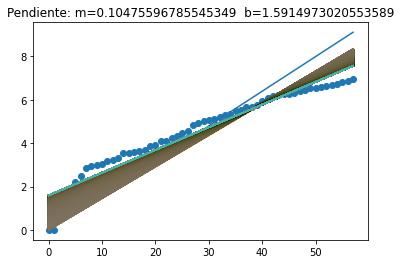

In [188]:
beta_0, beta_1 = linear_model(10000, 0.001)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


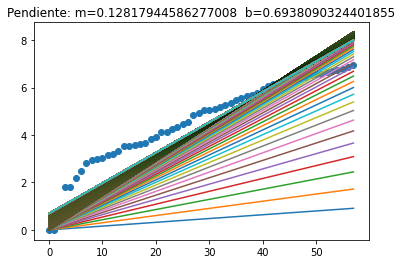

In [ ]:
beta_0, beta_1 = linear_model(20000, 0.0001)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


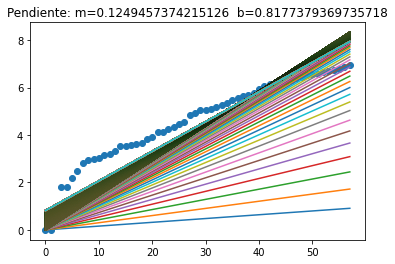

In [ ]:
beta_0, beta_1 = linear_model(25000, 0.0001)

### Prediccion del modelo

<img src="https://miro.medium.com/max/1920/1*GSAcN9G7stUJQbuOhu0HEg.png" height=275 width=500></img>

In [209]:
y_pred = beta_0 + beta_1 * x

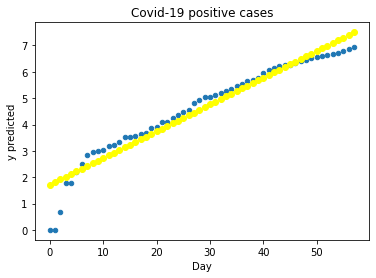

In [211]:
GT_confirmed.plot.scatter(x = 'Date', y = 'ln(confirmed)')
plt.scatter(x = GT_confirmed['Date'].astype(int), y = y_pred, color = 'yellow')
plt.title('Covid-19 positive cases')
plt.xlabel("Day")
plt.ylabel('y predicted')


plt.show()

### Mean Squared Error(MSE): Cost Function

<img heigth=500 width=400 src="https://cdn-images-1.medium.com/max/800/1*3wB5otkgKEiv9X6Gdd0r2Q@2x.png"/>

In [212]:
MSE = np.square(np.subtract(np.exp(y),np.exp(y_pred))).mean()
MSE

35653.85515030924

### Prediccion para el 30 de mayo:

In [213]:
pred_may_30 = beta_0 + beta_1 * 77
np.exp(pred_may_30)

13826.156436292536

In [ ]:

#%load_ext tensorboard
#%tensorboard --logdir f

## Conclusiones

- Despues de varios experimentos con un Learning rate de 0.0001 obtenemos los parametros beta_0, beta_1 pocos optimos ya que el MSE resulta ser muy alto.

- Con un Learning rate de 0.001 la recta se ajusta mejor a los datos(Se les aplico transformacion de log) y obtenemos un MSE mas bajo, sin embargo la prediccion fue 13,826 casos para el 10 de mayo cuando la verdadera cifra fue 4,607.

## Recomendaciones



- Se recomienda usar una regresion polinomial de grado dos ya que esta se ajusta mejor a la dispercion de los datos.